<a href="https://colab.research.google.com/github/PranikaRaheja/AlumUnity_PragyanSchool/blob/main/bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.11.11


In [2]:
# Fake News Detection using BERT
# =============================
# This notebook implements a fake news detector using BERT and the Hugging Face Transformers library

# Step 1: Install required libraries
!pip install transformers datasets pandas scikit-learn

# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
import os

# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00


In [3]:
# Step 3: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Install the Kaggle API package
!pip install -q kaggle

# Create a cell to upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()  # This will prompt you to upload the kaggle.json file you downloaded

# Set up the Kaggle credentials properly
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set proper permissions

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [5]:
# Download the fake news dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# Unzip the downloaded dataset
!unzip -q fake-and-real-news-dataset.zip

# Verify the files were extracted properly
!ls -la *.csv

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
 85% 35.0M/41.0M [00:00<00:00, 93.5MB/s]
100% 41.0M/41.0M [00:00<00:00, 90.4MB/s]
-rw-r--r-- 1 root root 62789876 Apr 19  2024 Fake.csv
-rw-r--r-- 1 root root 53582940 Apr 19  2024 True.csv


In [6]:
import pandas as pd

# Load the datasets
true_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

# Add labels: 0 for fake, 1 for true
true_news['label'] = 1
fake_news['label'] = 0

# Show some information about the datasets
print(f"True news dataset shape: {true_news.shape}")
print(f"Fake news dataset shape: {fake_news.shape}")

# Display a sample from each
print("\nSample from True news:")
print(true_news.head(1)[['title', 'text']].iloc[0])
print("\nSample from Fake news:")
print(fake_news.head(1)[['title', 'text']].iloc[0])

True news dataset shape: (21417, 5)
Fake news dataset shape: (23481, 5)

Sample from True news:
title    As U.S. budget fight looms, Republicans flip t...
text     WASHINGTON (Reuters) - The head of a conservat...
Name: 0, dtype: object

Sample from Fake news:
title     Donald Trump Sends Out Embarrassing New Year’...
text     Donald Trump just couldn t wish all Americans ...
Name: 0, dtype: object


In [7]:


# Combine the datasets
df = pd.concat([true_news, fake_news]).reset_index(drop=True)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Print information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"True news count: {len(true_news)}")
print(f"Fake news count: {len(fake_news)}")

# Display a few samples
print("\nSample True News:")
print(true_news.head(1)['text'].values[0][:300] + "...")
print("\nSample Fake News:")
print(fake_news.head(1)['text'].values[0][:300] + "...")

Dataset shape: (44898, 5)
True news count: 21417
Fake news count: 23481

Sample True News:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way ...

Sample Fake News:
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger a...


In [8]:
# Step 5: Preprocess the data
# We'll combine the title and text for better context
df['content'] = df['title'] + " " + df['text']


In [9]:
# Step 6: Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)


In [10]:
# Step 7: Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Step 8: Tokenize and prepare the datasets
def encode_texts(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

print("Tokenizing training texts...")
train_input_ids, train_attention_masks = encode_texts(train_texts, tokenizer)
print("Tokenizing validation texts...")
val_input_ids, val_attention_masks = encode_texts(val_texts, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for training and validation
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

Tokenizing training texts...


100%|██████████| 35918/35918 [04:48<00:00, 124.48it/s]


Tokenizing validation texts...


100%|██████████| 8980/8980 [01:10<00:00, 127.20it/s]


In [12]:

# Step 9: Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Step 10: Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Number of training epochs
epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# Step 11: Define training function
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device):
    # Store the average loss after each epoch for plotting
    loss_values = []

    for epoch in range(epochs):
        print(f"\n{'=' * 30}")
        print(f"Epoch {epoch+1} / {epochs}")
        print(f"{'=' * 30}")

        # Training
        model.train()
        total_loss = 0

        # Progress bar for training batches
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)

        for batch in progress_bar:
            # Unpack the batch and move to device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Clear any previously calculated gradients
            model.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and learning rate
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate average loss over the epoch
        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)

        print(f"Average training loss: {avg_train_loss:.4f}")


        # Validation
        model.eval()
        val_accuracy = []
        val_loss = []
        predictions = []
        true_labels = []

        for batch in tqdm(val_dataloader, desc="Validation"):
            # Unpack the batch and move to device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # No gradient calculation needed for validation
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            loss = outputs.loss
            logits = outputs.logits

            val_loss.append(loss.item())

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate batch accuracy
            batch_preds = np.argmax(logits, axis=1)
            batch_accuracy = (batch_preds == label_ids).mean()
            val_accuracy.append(batch_accuracy)

            # Store predictions and true labels
            predictions.extend(batch_preds)
            true_labels.extend(label_ids)


        # Print validation results
        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_accuracy = sum(val_accuracy) / len(val_accuracy)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {avg_val_accuracy:.4f}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=['Fake', 'True']))

        # Create confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.show()

        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
        }, f'checkpoint_epoch_{epoch}.pt')

    return model, loss_values

Starting model training...

Epoch 1 / 4


Training: 100%|██████████| 2245/2245 [56:07<00:00,  1.50s/it, loss=0.0002]


Average training loss: 0.0120


Validation: 100%|██████████| 562/562 [04:27<00:00,  2.10it/s]


Validation Loss: 0.0058
Validation Accuracy: 0.9991

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



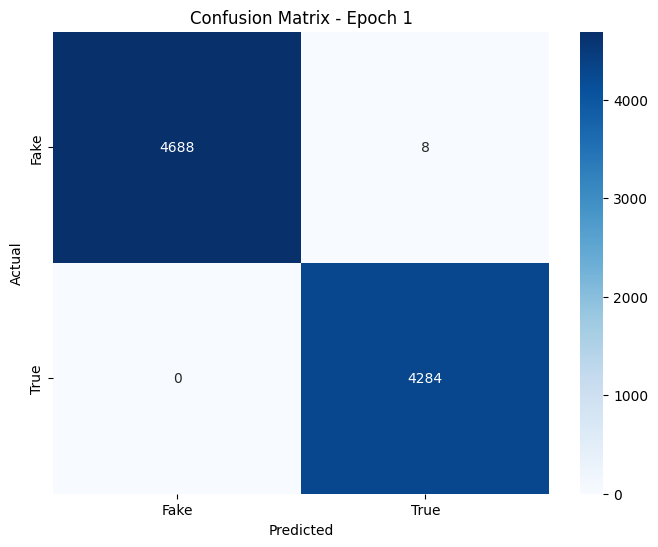


Epoch 2 / 4


Training: 100%|██████████| 2245/2245 [56:09<00:00,  1.50s/it, loss=0.0000]


Average training loss: 0.0006


Validation: 100%|██████████| 562/562 [04:26<00:00,  2.11it/s]


Validation Loss: 0.0005
Validation Accuracy: 0.9999

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



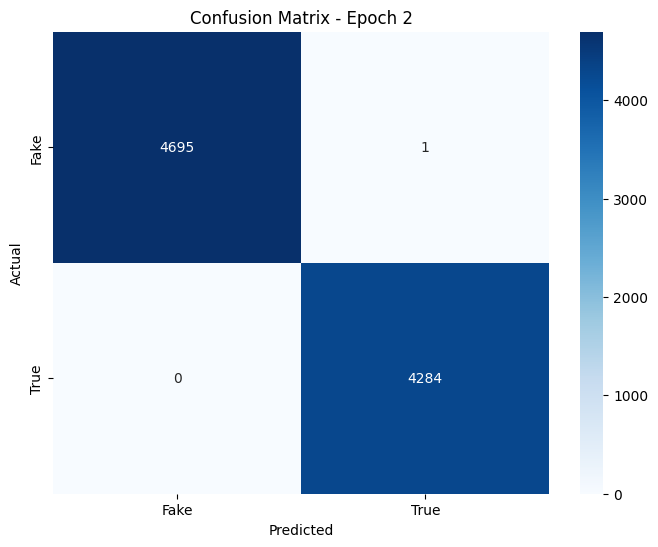


Epoch 3 / 4


Training: 100%|██████████| 2245/2245 [56:09<00:00,  1.50s/it, loss=0.0000]


Average training loss: 0.0001


Validation: 100%|██████████| 562/562 [04:27<00:00,  2.10it/s]


Validation Loss: 0.0000
Validation Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



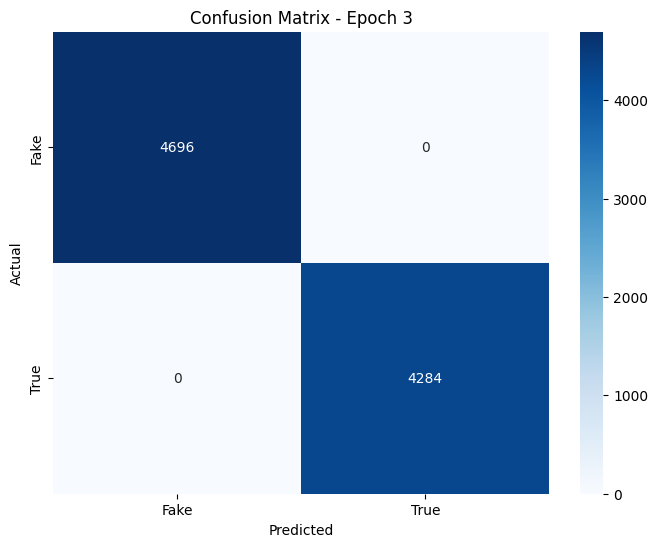


Epoch 4 / 4


Training: 100%|██████████| 2245/2245 [56:08<00:00,  1.50s/it, loss=0.0000]


Average training loss: 0.0000


Validation: 100%|██████████| 562/562 [04:27<00:00,  2.10it/s]


Validation Loss: 0.0005
Validation Accuracy: 0.9999

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        True       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



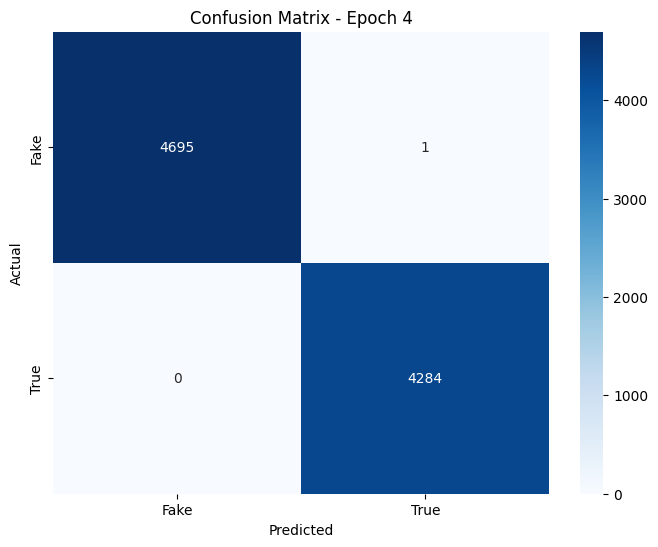

In [17]:


# Step 12: Train the model
print("Starting model training...")
model, loss_values = train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device)

In [18]:

# Step 13: Save the trained model
model_save_path = 'fake_news_bert_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to fake_news_bert_model


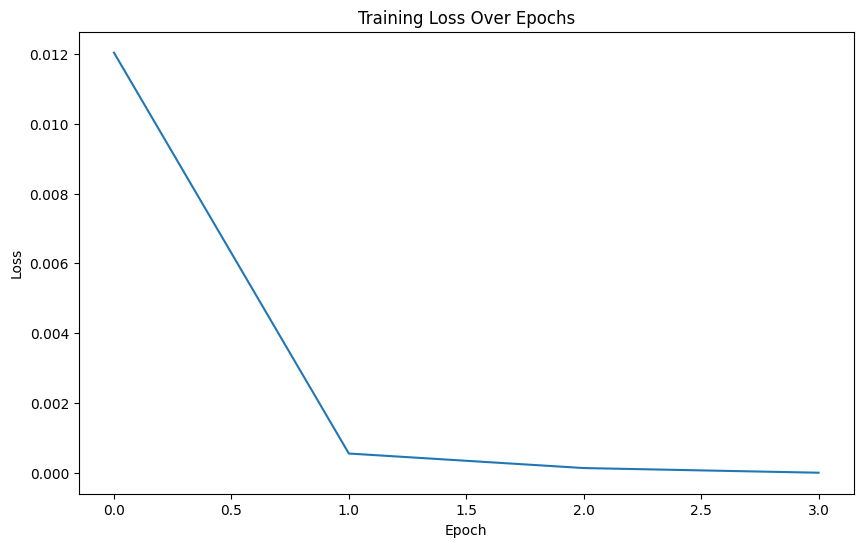

In [19]:


# Step 14: Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:
# Step 15: Create a function for making predictions on new text
def predict_fake_news(text, model, tokenizer, device):
    # Tokenize the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move tensors to the device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get prediction probabilities and class
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]
    pred_class = np.argmax(probs)

    result = {
        'prediction': 'True' if pred_class == 1 else 'Fake',
        'fake_probability': float(probs[0]),
        'true_probability': float(probs[1])
    }

    return result


In [21]:


# Step 16: Test with a few examples
test_texts = [
    "Scientists discover new planet that could support human life",
    "BREAKING: President secretly working with aliens to control world population"
]

print("\nTesting model with example texts:")
for text in test_texts:
    result = predict_fake_news(text, model, tokenizer, device)
    print(f"\nText: {text}")
    print(f"Prediction: {result['prediction']}")
    print(f"Fake probability: {result['fake_probability']:.4f}")
    print(f"True probability: {result['true_probability']:.4f}")


Testing model with example texts:

Text: Scientists discover new planet that could support human life
Prediction: Fake
Fake probability: 0.9999
True probability: 0.0001

Text: BREAKING: President secretly working with aliens to control world population
Prediction: Fake
Fake probability: 0.9999
True probability: 0.0001
